# TODO list fra mandag d. 24/4 kl.15:36

Jeg skal fikse/finde ud af hvordna de der k-vektor fungere med class og Kn.

Mit indtryk er at jeg bliver nød til at kalde class rigtig mange mange gange og der lyder lidt uhyggeligt.

Så få fat i Thomas eller Emil.


$\ddot{D}+\mathcal{H}\dot{D}-\frac{3}{2}\frac{H_0^2\Omega_m}{a}D=0$

$(\mathcal{H}\dot{D}D+\ddot{D}D+2\dot{D}^2)b_-+(4D\dot{D}+\mathcal{H}D^2)\dot{b}_-+2D^2\ddot{b}_-=\frac{3}{2}H_0^2 \Omega_m\frac{D^2}{a}$

For now let us assume equilateral configurations, thsi means $k_1\sim k_2 \sim k_3 \rightarrow \hat{k}_1 \cdot\hat{k}_2 = |k|^2 \cos(60^{\circ})=\frac{1}{2}|k|^2 $ 



In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv
import numpy as np
import scipy.special as special
from time import time

cs(1)=0.00019477974533539888
34.52612294026117
Test run


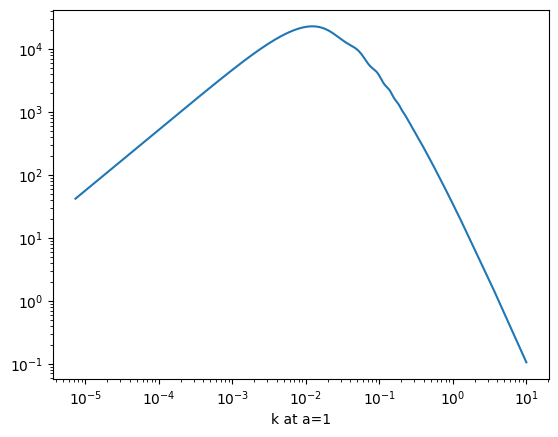

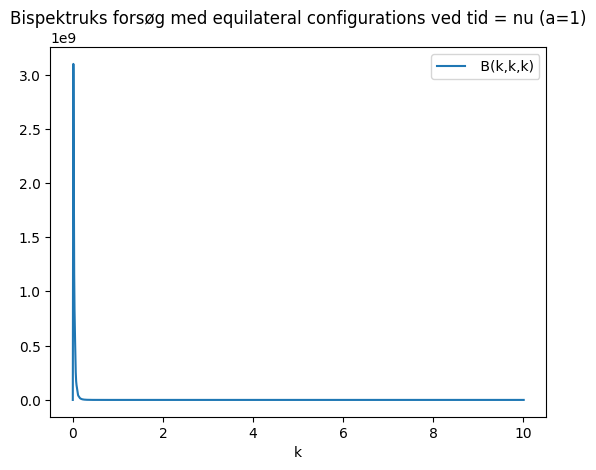

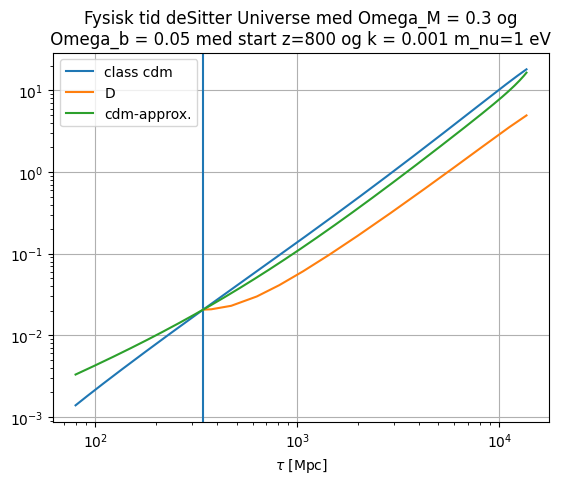

In [2]:
def TEST(kvec=[1],k_ind=0,z=800,mv_test=1 ,   Omega_M = 0.3,Omega_b=0.05,PLOT_FIGUR=True,div_med_a=False):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 #,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv

    print(f"{cs(1)=}")
    # henter class data
    #=======================
    delta_class = pts[k_ind]["delta_cdm"]
    theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    a_class = pts[k_ind]["a"]

    interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
    delta_interp = scipy.interpolate.interp1d(tau_class,delta_class)
    theta_interp = scipy.interpolate.interp1d(tau_class,theta_class)
    a_interp = scipy.interpolate.interp1d(tau_class,a_class)
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)
    
    a0 = 1/(1+z)
    a_span = [a0,1]
    T0 = float(interp_tau_from_a(a0))
    delta0 = delta_interp(T0)
    t0 = tau_class[-1]
    tspan = [T0,t0]
    t = np.logspace(np.log10(T0),np.log10(t0),100)

    def Dfunc(tau,y):
        a = a_interp(tau)
        D = y[0]
        dD = y[1]
        d2D = - H(a) * dD + (3/2) * H0*H0 * Omega_M * D / a
        
        b = y[2]
        db = y[3]
        d2b = 1/(2*D*D) * (3/2 * H0**2 * Omega_M * D**2 /a - (H(a)*dD*D+d2D*D+2*dD**2)*b - (4*D*dD+H(a)*dD**2)*db)
        return [dD,d2D,db,d2b]

    start0 = [delta_interp(T0),theta_interp(T0),0,0]
    sol = sc.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
    D = scipy.interpolate.interp1d(sol.t,-sol.y[0])
    b = scipy.interpolate.interp1d(sol.t,-sol.y[2])
    t = sol.t
    
    #plt.loglog(t,D(t),label="D")
    #plt.loglog(t,-b(t),label="b_")
    
    norm = lambda x: np.linalg.norm(x)
    
    def KN(k1,k2,k ,t = t0):
        v = 7/3 * b(t)
        bn = 1
        an = (7-3*v)/14
        return (bn - an) + bn/2 * np.vdot(k1,k2) * (1/norm(k1)**2 + 1/norm(k2)**2) + an * 1/(norm(k1)**2 * norm(k2)**2) * np.vdot(k1,k2)**2
    
    def KN2(k ,t = t0):
        v = 7/3 * b(t)
        bn = 1
        an = (7-3*v)/14
        return (bn - an) + bn/2 * 1**2 *0.5 * (k/k+k/k) + an * (1**2 * 1/2)**2
    
    delta_list = {kind:pts[i]["delta_cdm"][-1] for i,kind in enumerate(kvec)}
    #print(delta_list)
    #print(delta_list[1])
    tranf = cosmo.get_transfer(z=0)
    #print(tranf.keys())
    prim = cosmo.get_primordial()
    #print(prim.keys())

    k = tranf['k (h/Mpc)'] * h
    
    
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    plt.loglog(k, 2*np.pi**2 * tranf["d_m"]** 2 *k**(-3) *  prim_interp(k) * h**3,label="matter")
    plt.xlabel("k at a=1")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *k**(-3) *  prim_interp(k) * h**3
    print(p(1))
    
    def Bispektrum(k):
        return 2 * (p(k)*p(k) * KN2(k)
                    +p(k)*p(k) * KN2(k) 
                    +p(k)*p(k) * KN2(k) )
    
    
    #print(Bispektrum(1))
    B = [Bispektrum(i) for i in kvec]
    plt.figure(np.random.randint(0,100))
    plt.title("Bispektruks forsøg med equilateral configurations ved tid = nu (a=1)")
    #plt.loglog(k,k**6*Bispektrum(k), label="k^6* B(k,k,k)")
    plt.plot(k,Bispektrum(k), label=" B(k,k,k)")
    plt.xlabel("k")
    plt.legend()
    
    # her sætter vi det op sådan at når jeg ved hvordna jeg laver de der k-vektorer så skulle det gern blive forholdvis nemt.
    
    def KN(k1,k2,k ,t = t0):
        v = 7/3 * b(t)
        bn = 1
        an = (7-3*v)/14
        return (bn - an) + bn/2 * np.vdot(k1,k2) * (1/norm(k1)**2 + 1/norm(k2)**2) + an * 1/(norm(k1)**2 * norm(k2)**2) * np.vdot(k1,k2)**2
        
    
    
    
    plt.figure(np.random.randint(0,100))
    plt.axvline(T0)
    plt.plot(tau_class,-delta_class,label="class cdm")
    plt.xlabel("$\\tau$ [Mpc]")
    plt.loglog(t,D(t),label="D")
    plt.loglog(tau_class,-delta0/a0*a_class,label="cdm-approx.")
    plt.legend()
    plt.title("Fysisk tid deSitter Universe med Omega_M = %s og\n Omega_b = %s med start z=%s og k = %s m_nu=%s eV " %(Omega_M,Omega_b,z,kvec[k_ind],mv_test))
    print("Test run")
    #print(f"{KN(k1,k2,k3)=}")
    plt.grid()
    
kvec1=list(np.logspace(-3,1,10))
TEST(kvec = kvec1)#[1e-3,1e-2,1e-1,1e0,1e1,1e2])

cs(1)=0.00019477974533539888
7.333401129010708e-06 10.00597014925373
34.52612294026117
reduceret_B_spektrum(1,1,np.pi/3)=-0.0592098182731762
Q_equilateral(1,1,1)=0.5714285714285714


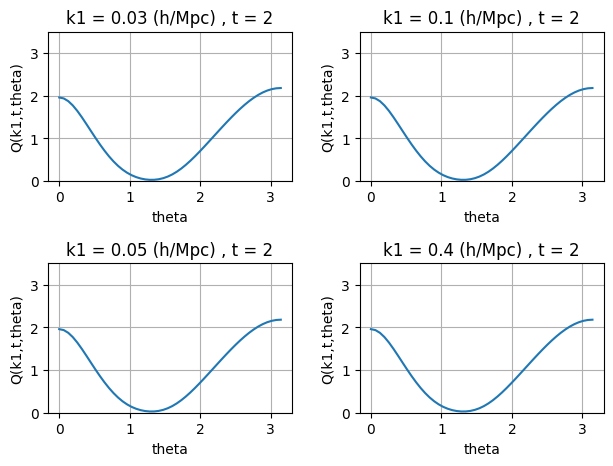

In [48]:
def TEST(kvec=[1],k_ind=0,z=800,mv_test=1 ,   Omega_M = 0.3,Omega_b=0.05,PLOT_FIGUR=True,div_med_a=False,EdSitter=True):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 #,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv

    print(f"{cs(1)=}")
    # henter class data
    #=======================
    delta_class = pts[k_ind]["delta_cdm"]
    theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    a_class = pts[k_ind]["a"]

    interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
    delta_interp = scipy.interpolate.interp1d(tau_class,delta_class)
    theta_interp = scipy.interpolate.interp1d(tau_class,theta_class)
    a_interp = scipy.interpolate.interp1d(tau_class,a_class)
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)
    
    a0 = 1/(1+z)
    a_span = [a0,1]
    T0 = float(interp_tau_from_a(a0))
    delta0 = delta_interp(T0)
    t0 = tau_class[-1]
    tspan = [T0,t0]
    t = np.logspace(np.log10(T0),np.log10(t0),100)

    def Dfunc(tau,y):
        a = a_interp(tau)
        D = y[0]
        dD = y[1]
        d2D = - H(a) * dD + (3/2) * H0*H0 * Omega_M * D / a
        
        b = y[2]
        db = y[3]
        d2b = 1/(2*D*D) * (3/2 * H0**2 * Omega_M * D**2 /a - (H(a)*dD*D+d2D*D+2*dD**2)*b - (4*D*dD+H(a)*dD**2)*db)
        return [dD,d2D,db,d2b]

    start0 = [delta_interp(T0),theta_interp(T0),0,0]
    sol = sc.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
    D = scipy.interpolate.interp1d(sol.t,-sol.y[0])
    b = scipy.interpolate.interp1d(sol.t,-sol.y[2])
    t = sol.t
    
    #plt.loglog(t,D(t),label="D")
    #plt.loglog(t,-b(t),label="b_")
    
    norm = lambda x: np.linalg.norm(x)
    
    def KN(k1,k2,k3,t = t0):
        v = 7/3 * b(t)
        bn = 1
        an = (7-3*v)/14
        return (bn - an) + bn/2 *1/2* (k2/k1 + k1/k2)+ an *1/4**2
    
    def KN2(k ,t = t0): # for equivalateral triangles.
        v = 7/3 * b(t)
        bn = 1
        an = (7-3*v)/14
        if EdSitter==True:
            an = 2/7
        return (bn - an) + bn/2 * 1/2**2 *0.5 * (k/k+k/k) + an * (1**2 * 1/2)**2
    
    
    delta_list = {kind:pts[i]["delta_cdm"][-1] for i,kind in enumerate(kvec)}
    #print(delta_list)
    #print(delta_list[1])
    tranf = cosmo.get_transfer(z=0)
    #print(tranf.keys())
    prim = cosmo.get_primordial()
    #print(prim.keys())

    k = tranf['k (h/Mpc)'] * h
    print(min(k),max(k))
    
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    #plt.figure(np.random.randint(0,10000))
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    #plt.loglog(k, 2*np.pi**2 * tranf["d_m"]** 2 *k**(-3) *  prim_interp(k) * h**3,label="matter")
    
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    print(p(1))
    
    
    def K(k1,t,theta,tid = t0/2):
        k2 = k1 * t
        v = 7/3 * b(tid)
        bn = 1
        an = (7-3*v)/14
        """
        if EdSitter == True: #if Einstein deSitter
            an = 2/7"""
        res= (bn - an) + bn/2 *  np.cos(np.pi-theta) * (k2/k1 + k1/k2) + an * (np.cos(np.pi-theta))**2
        return res 
    
    
    # DEN ER MEGEA GAL HER LAD VÆRD MED ATT BRUGE K DIN TORSK 
    def reduced_Bispektrum(k1,t,theta):        
        k2 = t * k1
        k3 = np.sqrt((k2 * np.sin(theta))**2 + (k2*np.cos(theta)+k1)**2)
        res =  2 *  (p(k1)*p(k2) * K(k1,k2,k3)
                    +p(k3)*p(k1) * K(k3,k1,k2) 
                    +p(k2)*p(k3) * K(k2,k3,k1)) / (p(k1)*p(k2)+p(k3)*p(k1)+p(k2)*p(k3))
        return res
    
    def reduceret_B_spektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        #print("theta2 = %s $\pi$"%(theta2/np.pi))
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        # vi skal også bruge de forskellige skaleringer 
        
        t2 = k3/k2
        
        t3 = k1/k3
        
        res =  2 *  (p(k1)*p(k2) * K(k1,t,theta)
                    +p(k3)*p(k1) * K(k3,t3,theta3) 
                    +p(k2)*p(k3) * K(k2,t2,theta2)) / (p(k1)*p(k2)+p(k3)*p(k1)+p(k2)*p(k3))
        return res
      
    print(f"{reduceret_B_spektrum(1,1,np.pi/3)=}")
    def Q_equilateral(k1,k2,k3): # its a bit weird
        #v = 7/3 * b(tid)
        bn = 1
        #an = (7-3*v)/14
        an = 2/7
        res= (bn - an) + bn/2 *(-1/2)* (k2/k1 + k1/k2) + an * (-1/2)**2
        return res *2
    print(f"{Q_equilateral(1,1,1)=}") # det giver 0.57 som er det rigtige!!!!!!!!!!!!
    
    fig = plt.figure()
    ax = fig.subplots(nrows=2, ncols=2)
    #plt.figure(12312312312123)
    
    theta = np.linspace(0,np.pi,50)
    k1 = 0.03 / h
    
    k_list_test = [0.03,0.1,0.05,0.4]
    t = 2
    k_i = 0
    
    for row in ax:
        for col in row:
            col.plot(theta,reduceret_B_spektrum(k1,t,theta))#,label="Please virk")
            
            col.set_title("k1 = %s (h/Mpc) , t = %s"% (k_list_test[k_i],t))
            k_i += 1
            col.set_xlabel("theta")
            col.set_ylim([0,3.5])
            col.grid()
            col.set_ylabel("Q(k1,t,theta)",rotation=90)
    
    #plt.
    plt.subplots_adjust(top=1.2)
    #plt.legend()
    
    fig.tight_layout(pad=1.2)
    
    
    print("="*50)
    """print(f"{reduced_Bispektrum(1,2,2*np.pi/3)=}")
    print("="*50)
    print(f"{reduced_Bispektrum(1,1,np.pi/3)=}")
    print("="*50)
    print(f"{reduced_Bispektrum(1,1,np.pi/3)=}")
    print("="*50)
    print(f"{K(1,1,2*np.pi/3)=}")
    print("="*50)
    print(f"{K(1,1,np.pi/3)=}")
    print("="*50)
    print(f"{KN(1,1,1)=}")
    print(f"{KN(2,2,2)=}")
    print(f"{2*KN(1,1,1)=}")"""
    # DEN ER MEGEA GAL HER LAD VÆRD MED ATT BRUGE K DIN TORSK 
    def B(k1,theta,t):
        # der er lige nogle vinkings problemer
        k2 = t * k1
        #
        k3 = np.sqrt((k2*np.sin(np.pi-theta))**2 + (k2*np.cos(np.pi-theta)+k1)**2)        
        res =  2 *  (  p(k1)*p(k2) * K(k1,k2,k3)
                     + p(k3)*p(k1) * K(k3,k1,k2)
                     + p(k2)*p(k3) * K(k2,k3,k1))
        return res
    
    
    
    """plt.figure(np.random.randint(0,10000))
    tol = 1e-3
    n = 100
    mat = np.empty((n,n))
    k1 = 1
    for i in range(n):
        for j in range(n):
            t  = 1/2 * ( 1 + i/n)
            if 0.5> t or t>1:
                break
            theta =  np.pi -np.arccos(1/2*( 1 + j/n))
            if 2 * t * np.cos(np.pi - theta) >= 1:
                res =B(k1,theta,t)
                mat[i,j] = res
            else:
                mat[i,j]=None
    plt.matshow(mat,interpolation="spline16")
    plt.title("k1=%s"%k1)
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_bottom()
    plt.xlabel=("$\\theta$ fra 2$\pi$/3 til $\pi$") # jeg arbejder lige på at få fikset det her.
    plt.colorbar()"""
kvec1=list(np.logspace(-3,1,3))
TEST(kvec = kvec1)
#TEST(kvec = kvec1,EdSitter=True)

 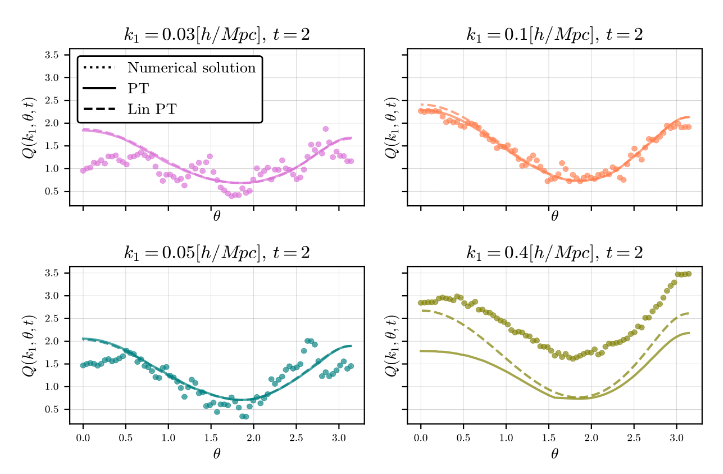

Sjålet fra Johans Speciale

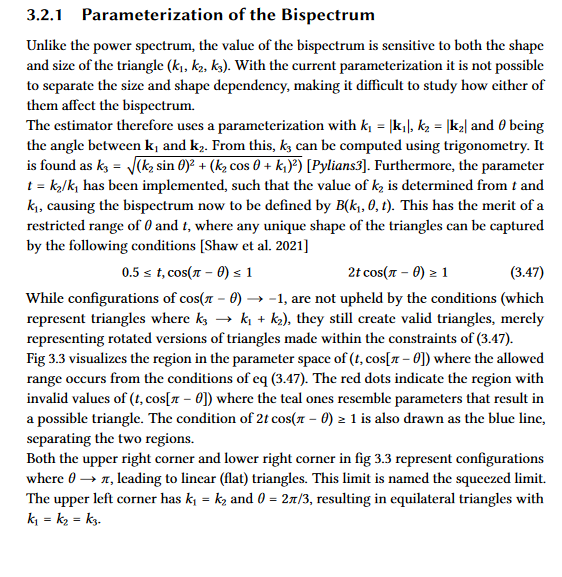

 𝑘3 = √(𝑘2 sin 𝜃)2 + (𝑘2 cos 𝜃 + 𝑘1)2) 

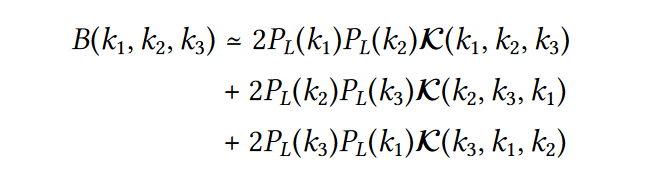

Fra artiklen shaw et al. (Tjek JohaNNS SPECIALE)
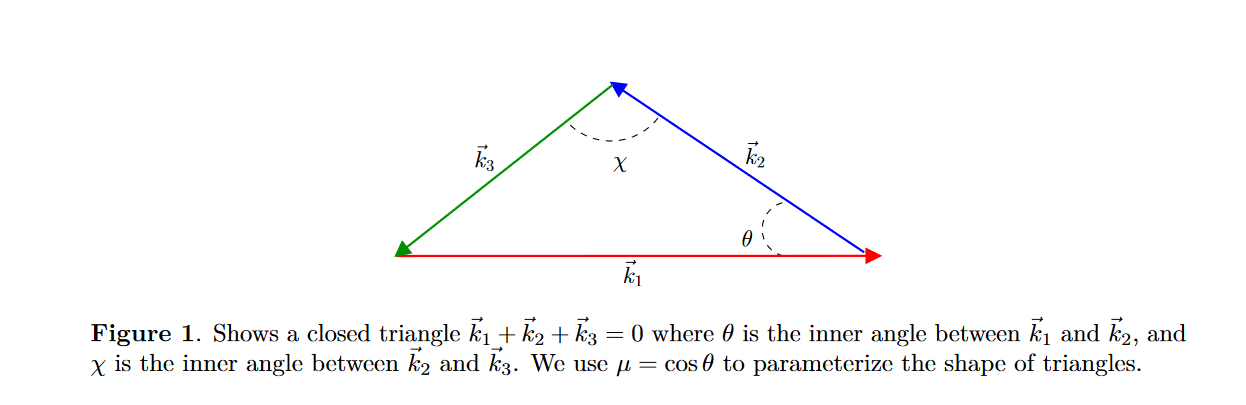


dU BØR NOK SKIMME DENNE ARTIKEL 
https://arxiv.org/abs/2001.10243

'n_list=[0.5,0.6,0.7,0.8,0.9,1]\nxi = list(range(len(n_list)))\nplt.xticks(n_list,xi)'

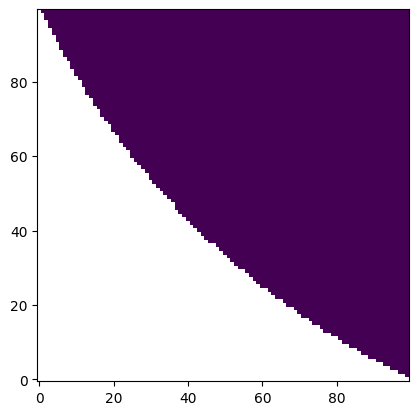

In [6]:
tol = 1e-3
n = 100
mat = np.empty((n,n))
#print(mat)
theta_list = np.zeros(n)
t_list =  np.zeros(n)
k1 = 0.3
#print(theta_list)
for i in range(n):
    for j in range(n):
        t  = 1/2 * ( 1 + i/n)
        #>theta = np.pi /3 + np.pi / 6 * j / n
        theta = np.pi - np.arccos(1/2*( 1 + j/n))
        #if theta not in theta_list:
        """if theta_list[j] == 0 and i == 0:
            theta_list[j] = theta"""
        #print(t,theta)
        #if i % 3 == 0:
         #   print(t,np.cos(np.pi-theta))
        if 2 * t * np.cos(np.pi - theta) >= 1:
            mat[i,j] = 1
        else:
            mat[i,j]=None
#print(theta_list)
plt.matshow(mat)#,interpolation="spline16")
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_bottom()
"""n_list=[0.5,0.6,0.7,0.8,0.9,1]
xi = list(range(len(n_list)))
plt.xticks(n_list,xi)"""

In [ ]:
import matplotlib


In [ ]:
"""import matplotlib.pyplot as plt
import numpy as np

# Create a 2D array of random data
data = np.random.rand(80, 80)

# Plot the data using matshow
plt.matshow(data)

# Set the x-axis tick locations and labels
x_tick_locs = np.arange(0, 81, 3)
x_tick_labels = np.arange(0.5, 1.1, 0.1)
plt.xticks(x_tick_locs, x_tick_labels)

# Show the plot
plt.show()
"""

Jeg vil gerne replikere denne figur fra Shaw_2021 k1 = 0.88 Mpc^-1
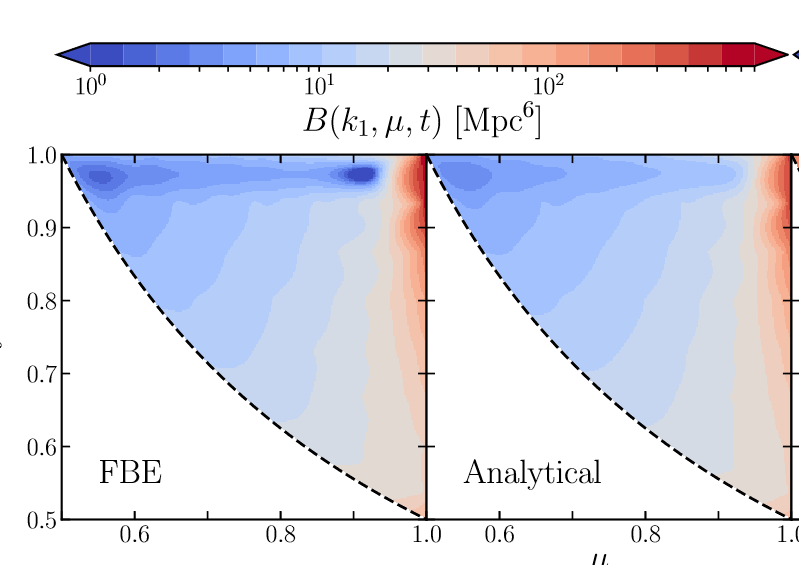